<a href="https://colab.research.google.com/github/sazzeb/csce-5215/blob/main/statistical_learning_methods_id_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keep notebook output clean: some BLAS backends can emit benign RuntimeWarnings
# from internal matrix multiplications during SGD fit/predict.
warnings.filterwarnings(
    'ignore',
    category=RuntimeWarning,
    message=r'.*encountered in matmul.*',
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    mean_squared_error,
    r2_score,
)
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDRegressor, SGDClassifier

RNG_SEED = 5215
rng = np.random.default_rng(RNG_SEED)

In [2]:

student_login_id = 'es09307'

if not student_login_id:
    student_login_id = input('Enter your student login ID: ').strip()

student_login_id = student_login_id.strip()
if not student_login_id:
    raise ValueError('Empty login ID. Please enter something like eos0030.')

# 'Last digit of the login ID' is interpreted literally as the last digit that appears
# anywhere in the string (more robust than assuming the final character is a digit).
digits_in_id = [ch for ch in student_login_id if ch.isdigit()]
if not digits_in_id:
    raise ValueError('No digits found in login ID; cannot apply the n-based rule.')

n = int(digits_in_id[-1])

if n in {0, 3, 6, 9}:
    chosen_method = 'decision_tree'
elif n in {1, 4, 7}:
    chosen_method = 'linear_regression'
elif n in {2, 5, 8}:
    chosen_method = 'logistic_regression'
else:
    raise RuntimeError('Unexpected digit mapping; check the rule.')

print('Login ID:', student_login_id)
print('Last digit n:', n)
print('Chosen method:', chosen_method)

Login ID: es09307
Last digit n: 7
Chosen method: linear_regression


In [4]:
BIG_N = 250_000
P = 40
TEST_FRAC = 0.2

# Safety: define RNG_SEED if this cell is run standalone
if 'RNG_SEED' not in globals():
    RNG_SEED = 5215

def synthesize_big_table(task: str, n_rows: int, n_features: int, seed: int):
    if task == 'regression':
        X_arr, y_arr, coef = make_regression(
            n_samples=n_rows,
            n_features=n_features,
            n_informative=max(5, n_features // 3),
            noise=18.0,
            coef=True,
            random_state=seed,
        )
        y_arr = y_arr.astype(np.float32)
        X_arr = X_arr.astype(np.float32)
        return X_arr, y_arr, coef

    if task == 'classification':
        X_arr, y_arr = make_classification(
            n_samples=n_rows,
            n_features=n_features,
            n_informative=max(8, n_features // 2),
            n_redundant=n_features // 6,
            n_repeated=0,
            n_classes=2,
            weights=[0.65, 0.35],
            flip_y=0.015,
            class_sep=1.1,
            random_state=seed,
        )
        y_arr = y_arr.astype(np.int64)
        X_arr = X_arr.astype(np.float32)
        return X_arr, y_arr, None

    raise ValueError('task must be regression or classification')

task_kind = 'regression' if chosen_method == 'linear_regression' else 'classification'
X_big, y_big, hidden_coef = synthesize_big_table(task_kind, BIG_N, P, seed=RNG_SEED)

feature_names = [f'col_{i:02d}' for i in range(X_big.shape[1])]
frame_X = pd.DataFrame(X_big, columns=feature_names)
target_y = pd.Series(y_big, name='y')

print('X shape:', frame_X.shape)
print('y shape:', target_y.shape)
print('X dtype:', frame_X.dtypes.iloc[0])
if task_kind == 'classification':
    print('Class balance:', target_y.value_counts(normalize=True).round(4).to_dict())
else:
    print('y mean/std:', float(target_y.mean()), float(target_y.std()))

frame_X.head()

X shape: (250000, 40)
y shape: (250000,)
X dtype: float32
y mean/std: -0.16044482588768005 217.0926055908203


,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_08,col_09,...,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39
0,-0.233332,1.026850,-1.924554,-0.072568,-0.250375,-0.873364,-0.370986,0.302381,0.635692,0.041939,...,-0.801731,2.021600,0.071221,-0.232305,0.442185,-0.145473,1.286285,0.853294,-0.981636,0.353343
1,0.894686,-0.607210,-0.400373,2.424117,1.183763,0.083922,0.588976,0.392873,-2.141452,0.387318,...,-0.033099,-2.490791,-0.528652,0.790533,-0.217243,1.402817,0.059020,-0.108630,-0.480665,0.668703
2,-0.227028,0.153576,-1.094846,-0.073924,-0.299428,-0.326171,-0.666798,1.187043,0.277567,1.820019,...,-0.740628,-0.197911,0.131558,0.388662,-0.212077,-0.363162,-1.003882,0.854991,1.464574,1.579022
3,0.031794,0.873050,0.235995,-0.712163,0.155579,0.577527,-0.574898,0.697986,-0.516574,-1.241240,...,0.818920,0.475462,0.523815,-0.528353,1.157990,-0.006882,0.872677,-1.117377,-0.058000,-1.193756
4,0.189039,-1.972782,0.924363,-0.100783,0.021968,-0.179688,0.688360,-1.128789,0.923584,0.283214,...,-1.552493,0.108055,-1.334323,-1.333625,-1.556289,-0.323483,0.596349,1.109918,1.425048,-0.047167


In [5]:
# Train/test split
if task_kind == 'classification':
    X_train, X_test, y_train, y_test = train_test_split(
        frame_X, target_y, test_size=TEST_FRAC, random_state=RNG_SEED, stratify=target_y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        frame_X, target_y, test_size=TEST_FRAC, random_state=RNG_SEED
    )

print('Train:', X_train.shape, y_train.shape)
print('Test :', X_test.shape, y_test.shape)

Train: (200000, 40) (200000,)
Test : (50000, 40) (50000,)


In [7]:
def evaluate_classification(model, X_te, y_te, title: str):
    y_hat = model.predict(X_te)
    acc = accuracy_score(y_te, y_hat)
    print(f'{title} accuracy: {acc:.4f}')
    print()
    print(classification_report(y_te, y_hat, digits=4))

    cm = confusion_matrix(y_te, y_hat)
    plt.figure(figsize=(4.6, 3.8))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    plt.show()

    # AUC if we can produce scores
    auc = None
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_te)[:, 1]
        auc = roc_auc_score(y_te, proba)
    elif hasattr(model, 'decision_function'):
        score = model.decision_function(X_te)
        auc = roc_auc_score(y_te, score)

    if auc is not None:
        print(f'ROC-AUC: {auc:.4f}')
    else:
        print('ROC-AUC: skipped (no scores available)')

    return acc, auc

def evaluate_regression(model, X_te, y_te, title: str):
    y_hat = model.predict(X_te)
    mse = mean_squared_error(y_te, y_hat)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_te, y_hat)
    print(f'{title} RMSE: {rmse:.3f}')
    print(f'{title} R^2 : {r2:.4f}')

    plt.figure(figsize=(5.2, 4.2))
    plt.scatter(y_te.iloc[:2000], y_hat[:2000], s=8, alpha=0.35)
    plt.title('Predicted vs actual (first 2000 points)')
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    plt.tight_layout()
    plt.show()

    return rmse, r2

In [8]:
model = None
model_label = None

if chosen_method == 'decision_tree':
    # Regularized tree so it trains quickly on BIG_N rows
    model = DecisionTreeClassifier(
        max_depth=12,
        min_samples_leaf=60,
        random_state=RNG_SEED,
    )
    model.fit(X_train, y_train)
    model_label = 'DecisionTreeClassifier'

elif chosen_method == 'linear_regression':
    # SGD is a good big-data baseline for linear regression.
    model = Pipeline([
        ('scale', StandardScaler()),
        ('sgd', SGDRegressor(
            loss='squared_error',
            penalty='l2',
            alpha=1e-4,
            max_iter=1000,
            tol=1e-3,
            random_state=RNG_SEED,
        )),
    ])
    with warnings.catch_warnings():
        warnings.filterwarnings(
            'ignore',
            category=RuntimeWarning,
            message=r'.*encountered in matmul.*',
        )
        model.fit(X_train, y_train)
    model_label = 'SGDRegressor (scaled)'

elif chosen_method == 'logistic_regression':
    # Logistic regression via SGDClassifier(log loss) scales well.
    model = Pipeline([
        ('scale', StandardScaler()),
        ('sgd', SGDClassifier(
            loss='log_loss',
            penalty='l2',
            alpha=1e-4,
            max_iter=1000,
            tol=1e-3,
            random_state=RNG_SEED,
        )),
    ])
    with warnings.catch_warnings():
        warnings.filterwarnings(
            'ignore',
            category=RuntimeWarning,
            message=r'.*encountered in matmul.*',
        )
        model.fit(X_train, y_train)
    model_label = 'SGDClassifier(log_loss) (scaled)'

else:
    raise RuntimeError('Unknown chosen_method')

print('Trained:', model_label)

Trained: SGDRegressor (scaled)


SGDRegressor (scaled) RMSE: 17.988
SGDRegressor (scaled) R^2 : 0.9931


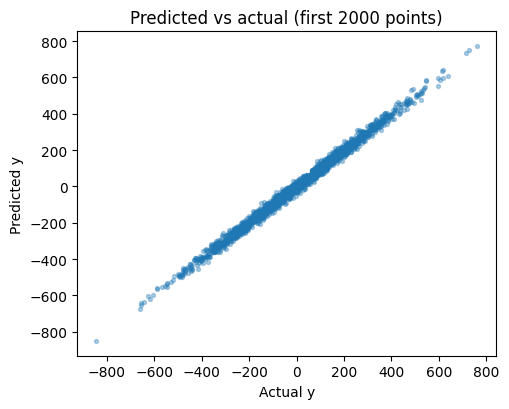

In [9]:
# Evaluate
if task_kind == 'classification':
    _ = evaluate_classification(model, X_test, y_test, title=model_label)
else:
    _ = evaluate_regression(model, X_test, y_test, title=model_label)